# Generating Mock Luminosity Data
*David Thomas 2017/01/18*

### Background
In this notebook we begin our exploration of the halo mass luminosity relation outlined [here](https://github.com/davidthomas5412/PanglossNotebooks/blob/master/Proposal_2017_01_10.ipynb). We extract a field of view and proceed to use the halos in the field of view to generate mock luminosity data.

### Data and Field of View
The data we use is from the Millennium Simulation, specifically the file 'GGL_los_8_0_0_0_0_N_4096_ang_4_Guo_galaxies_on_plane_27_to_63.images.txt'. We begin by cutting a $40 \times 40 arcmin^2$ field of view and plotting it with three combinations of cuts of (right ascension, declination, redshift). There are three features of the data that are disconcerting:
1. There are clear striations in z vs ra and z vs dec.
2. There is a lack of structure near the z=0 end of the dataset. Perhaps this an artifact of the simulation boundary.
3. There is a lack of high mass halos beyond z=2.

In the meantime we proceed with our analysis, when we resolve these issues we will rerun the pipeline below.

In [1]:
import pandas as pd
from massinference.angle import Angle

# opening, white-listing, renaming
usecols = ['GalID', 'pos_0[rad]', 'pos_1[rad]', 'M_Subhalo[M_sol/h]', 'z_spec']
guo = pd.read_table(
    '/Users/user/Code/Pangloss/data/GGL_los_8_0_0_0_0_N_4096_ang_4_Guo_galaxies_on_plane_27_to_63.images.txt', 
    usecols=usecols)
guo.rename(
    columns={'GalID': 'gal_id',
             'M_Subhalo[M_sol/h]': 'mass_h',
             'z_spec': 'z'
            }, 
    inplace=True)
guo = guo[guo['mass_h'] > 0]

# convert to arcmin
guo['ra'] = Angle.radian_to_arcmin(guo['pos_0[rad]'])
guo['dec'] = Angle.radian_to_arcmin(guo['pos_1[rad]'])

# field of view bounds
ra_i = guo['ra'].min()
dec_i = guo['dec'].min()
ra_f = ra_i + 40
dec_f = dec_i + 40
z_i = guo['z'].min()
z_f = guo['z'].max()

# clip data, fov = field of view
fov = guo[(guo['ra'] >= ra_i)
           & (guo['ra'] < ra_f)
           & (guo['dec'] >= dec_i)
           & (guo['dec'] < dec_f)].copy(deep=True)

fov.drop(['pos_0[rad]', 'pos_1[rad]'], axis=1, inplace=True)

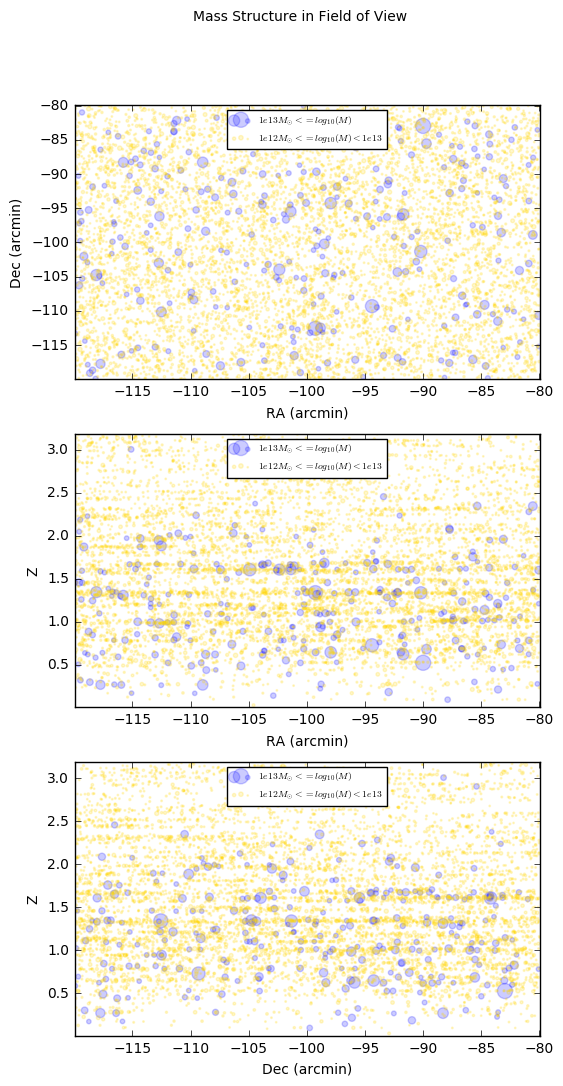

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt

from pylab import rcParams
rcParams['figure.figsize'] = 6, 12

heaviest = fov[fov.mass_h > 1e13]
others = fov[(fov.mass_h < 1e13) & (fov.mass_h > 1e12)]

ax = plt.subplot(3,1,1)
ax.scatter(x=heaviest['ra'],
                y=heaviest['dec'], 
                alpha=0.2, 
                color='blue',
                s=(heaviest['mass_h'] / 1e12)
               )
ax.scatter(x=others['ra'],
                y=others['dec'], 
                alpha=0.2, 
                color='gold',
                s=(others['mass_h'] / 1e12)
               )
ax.set_xlim([ra_i, ra_f])
ax.set_ylim([dec_i, dec_f])
plt.xlabel('RA (arcmin)')
plt.ylabel('Dec (arcmin)')
plt.legend([r'$1e13 M_{{\odot}} <= log_{{10}}(M) $',
                 r'$1e12 M_{{\odot}} <= log_{{10}}(M) < 1e13$'], 
           loc='upper center', fontsize=7)


ax = plt.subplot(3,1,2)
ax.scatter(x=heaviest['ra'],
                y=heaviest['z'], 
                alpha=0.2, 
                color='blue',
                s=(heaviest['mass_h'] / 1e12)
               )
ax.scatter(x=others['ra'],
                y=others['z'], 
                alpha=0.2, 
                color='gold',
                s=(others['mass_h'] / 1e12)
               )
ax.set_xlim([ra_i, ra_f])
ax.set_ylim([z_i, z_f])
plt.xlabel('RA (arcmin)')
plt.ylabel('Z')
plt.legend([r'$1e13 M_{{\odot}} <= log_{{10}}(M) $',
                 r'$1e12 M_{{\odot}} <= log_{{10}}(M) < 1e13$'], 
           loc='upper center', fontsize=7)



ax = plt.subplot(3,1,3)
ax.scatter(x=heaviest['dec'],
                y=heaviest['z'], 
                alpha=0.2, 
                color='blue',
                s=(heaviest['mass_h'] / 1e12)
               )
ax.scatter(x=others['dec'],
                y=others['z'], 
                alpha=0.2, 
                color='gold',
                s=(others['mass_h'] / 1e12)
               )
ax.set_xlim([dec_i, dec_f])
ax.set_ylim([z_i, z_f])
plt.xlabel('Dec (arcmin)')
plt.ylabel('Z')
plt.legend([r'$1e13 M_{{\odot}} <= log_{{10}}(M) $',
                 r'$1e12 M_{{\odot}} <= log_{{10}}(M) < 1e13$'], 
           loc='upper center', fontsize=7)
plt.gcf().suptitle('Mass Structure in Field of View')

### Model
For each halo in a fixed 1600 $arcmin^2$ field of view from the Millennium Simulation catalog we sample its mass from a prior mass distribution derived from the larger dateset, then sample its luminosity from a conditional lognormal distribution with variance $\sigma$. Next we apply multiplicative noise $\sigma_{obs}$ to the luminosities to get the observed luminosities (note: we cap this at the minimum luminosity). The result is a pandas dataframe with columns: 'gal_id', 'ra', 'dec', 'z', 'mass_h', 'lum_t', 'lum'. The PGM for our distribution is rendered below.

See http://www.nehalemlabs.net/prototype/blog/2013/12/16/how-to-do-inverse-transformation-sampling-in-scipy-and-numpy/ for more information on how we do the inverse transformation to sample from the halo mass PDF.

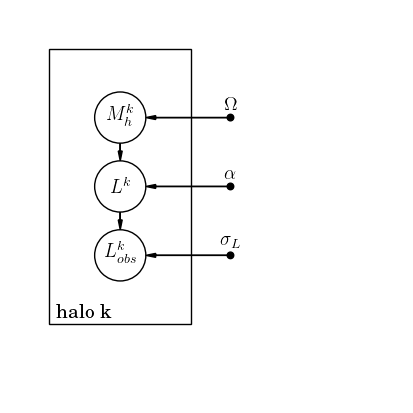

In [3]:
from matplotlib import rc
rc("font", family="serif", size=14)
rc("text", usetex=True)

import daft

pgm = daft.PGM([5, 5], origin=[0, 0])

#dimensions
plate_x = 0.5
plate_y = 1
plate_width = 1.8
plate_height = 3.5
plate_x_center = plate_x + (plate_width / 2.0)
plate_y_fourth = plate_height / 4.0
scale = 1.3

#plate
pgm.add_plate(daft.Plate([plate_x, plate_y, plate_width, plate_height], label="halo k"))

#nodes
pgm.add_node(daft.Node("m_h", "$M_h^k$", plate_x_center, plate_y + 3 * plate_y_fourth, scale=scale))
pgm.add_node(daft.Node("l", "$L^k$", plate_x_center, plate_y + 2 * plate_y_fourth, scale=scale))
pgm.add_node(daft.Node("l_obs", "$L^k_{obs}$", plate_x_center, plate_y + 1 * plate_y_fourth, scale=scale))

pgm.add_node(daft.Node("sigma_l", "$\sigma_L$", 2*plate_x_center, plate_y + 1 * plate_y_fourth, fixed=True))
pgm.add_node(daft.Node("alpha", r"$\alpha$", 2*plate_x_center, plate_y + 2 * plate_y_fourth, fixed=True))
pgm.add_node(daft.Node("omega", r"$\Omega$", 2*plate_x_center, plate_y + 3 * plate_y_fourth, fixed=True))

#edges
pgm.add_edge("m_h", "l")
pgm.add_edge("l", "l_obs")
pgm.add_edge("sigma_l", "l_obs")
pgm.add_edge("alpha", "l")
pgm.add_edge("omega", "m_h")

pgm.render()

Here we sample masses ... and compare the true and sampled distributions.

In [4]:
import scipy.interpolate as interpolate
import numpy as np

np.random.seed(7)

dist = np.log(guo['mass_h']) / np.log(10)
n_bins = 100
n_samples = len(fov)

hist, bin_edges = np.histogram(dist, bins=n_bins, density=True)
cum_values = np.zeros(bin_edges.shape)
cum_values[1:] = np.cumsum(hist * np.diff(bin_edges))
inv_cdf = interpolate.interp1d(cum_values, bin_edges)
r = np.random.rand(n_samples)
samples = inv_cdf(r)

from pylab import rcParams
rcParams['figure.figsize'] = 4, 4

fov['mass_sample'] = 10 ** samples

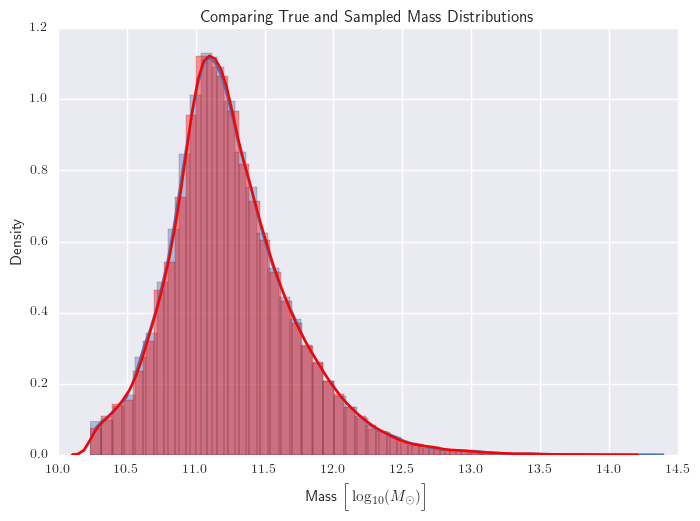

In [5]:
import seaborn as sns

sns.distplot(np.log(fov['mass_sample'].as_matrix()) / np.log(10))
sns.distplot(np.log(fov['mass_h'].as_matrix()) / np.log(10), color='red')
plt.xlabel('Mass $\Big[\log_{10}(M_{\odot})\Big]$')
plt.ylabel('Density')
plt.title('Comparing True and Sampled Mass Distributions')

Now we generate the conditional luminosities ...

In [6]:
sigma = 1
fov['lum'] = np.random.lognormal(np.log(fov['mass_sample']), sigma, len(fov))

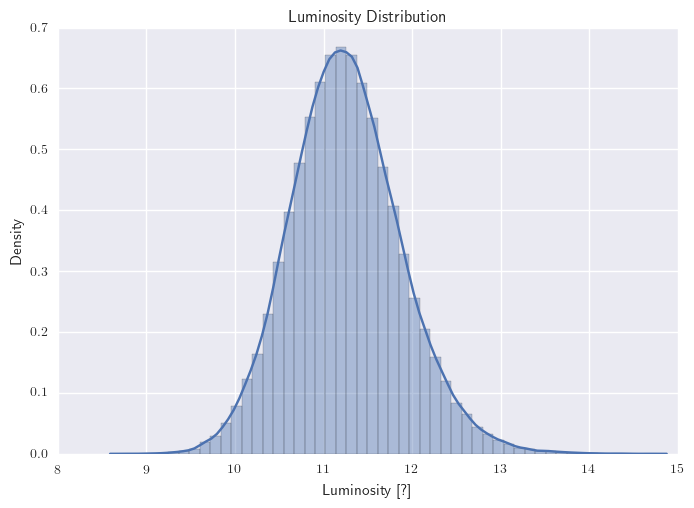

In [7]:
sns.distplot(np.log(fov['lum'].as_matrix()) / np.log(10))
plt.title('Luminosity Distribution')
plt.xlabel('Luminosity [?]')
plt.ylabel('Density')

Finally we add observational noise ...

In [8]:
sigma_obs = fov['lum'].std() / 100.0
fov['lum_obs'] = np.maximum(fov['lum'].min(), np.random.normal(fov['lum'], sigma_obs, len(fov)))

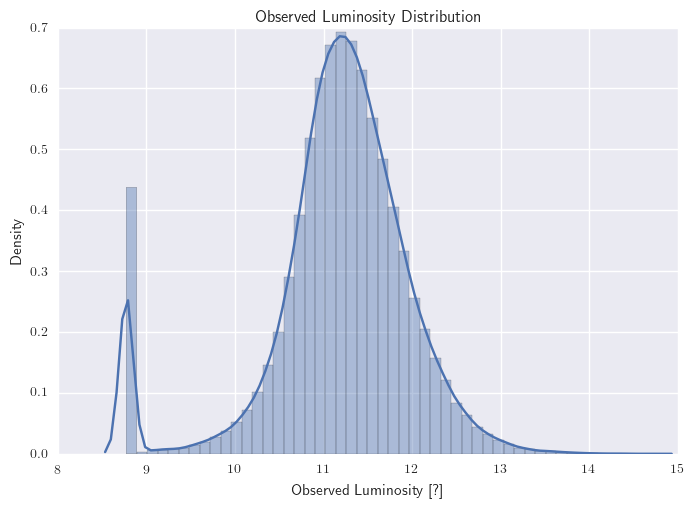

In [9]:
sns.distplot(np.log(fov['lum_obs']) / np.log(10))
plt.title('Observed Luminosity Distribution')
plt.xlabel('Observed Luminosity [?]')
plt.ylabel('Density')

Note: The minimum accumulates mass because we resample with a mean from each luminosity as opposed to the distribution of luminosities.

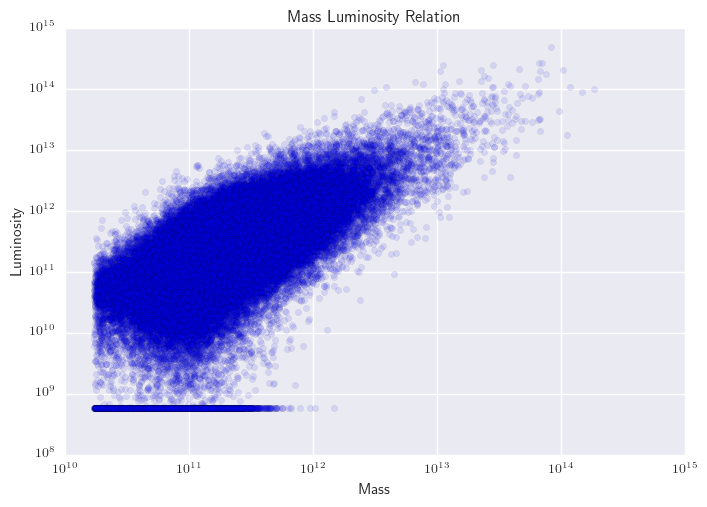

In [10]:
plt.scatter(fov['mass_sample'], fov['lum_obs'], alpha=0.1)
plt.gca().set_xscale("log", nonposx='clip')
plt.gca().set_yscale("log", nonposx='clip')
plt.title('Mass Luminosity Relation')
plt.xlabel('Mass')
plt.ylabel('Luminosity')

### Inference

Now that we have a mass-luminosity dataset we can check whether we can infer the original hyperparameters as a sanity check. Below is the log-likelihood function we will be using:

\begin{align*}
\chi^2 &= \sum^N_{i=1} \frac{(L^{obs}_i - L_i)^2}{\sigma^2}\\
Z_L &= (2\pi \sigma^2)^{N/2}\\
\log(L) &= -\log(Z_L) - \chi^2\\
\end{align*}

A PGM describing this new factorization is rendered below.

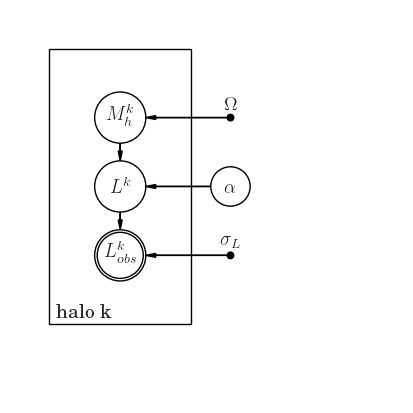

In [11]:
from matplotlib import rc
rc("font", family="serif", size=14)
rc("text", usetex=True)

import daft

pgm = daft.PGM([5, 5], origin=[0, 0], observed_style="inner")

#dimensions
plate_x = 0.5
plate_y = 1
plate_width = 1.8
plate_height = 3.5
plate_x_center = plate_x + (plate_width / 2.0)
plate_y_fourth = plate_height / 4.0
scale = 1.3

#plate
pgm.add_plate(daft.Plate([plate_x, plate_y, plate_width, plate_height], label="halo k"))

#nodes
pgm.add_node(daft.Node("m_h", "$M_h^k$", plate_x_center, plate_y + 3 * plate_y_fourth, scale=scale))
pgm.add_node(daft.Node("l", "$L^k$", plate_x_center, plate_y + 2 * plate_y_fourth, scale=scale))
pgm.add_node(daft.Node("l_obs", "$L^k_{obs}$", plate_x_center, plate_y + 1 * plate_y_fourth, scale=scale, observed=True))

pgm.add_node(daft.Node("sigma_l", "$\sigma_L$", 2*plate_x_center, plate_y + 1 * plate_y_fourth, fixed=True))
pgm.add_node(daft.Node("alpha", r"$\alpha$", 2*plate_x_center, plate_y + 2 * plate_y_fourth))
pgm.add_node(daft.Node("omega", r"$\Omega$", 2*plate_x_center, plate_y + 3 * plate_y_fourth, fixed=True))

#edges
pgm.add_edge("m_h", "l")
pgm.add_edge("l", "l_obs")
pgm.add_edge("sigma_l", "l_obs")
pgm.add_edge("alpha", "l")
pgm.add_edge("omega", "m_h")

pgm.render()

In [12]:
prior = np.random.uniform(0.5 * sigma_obs, 1.5 * sigma_obs, 10000)

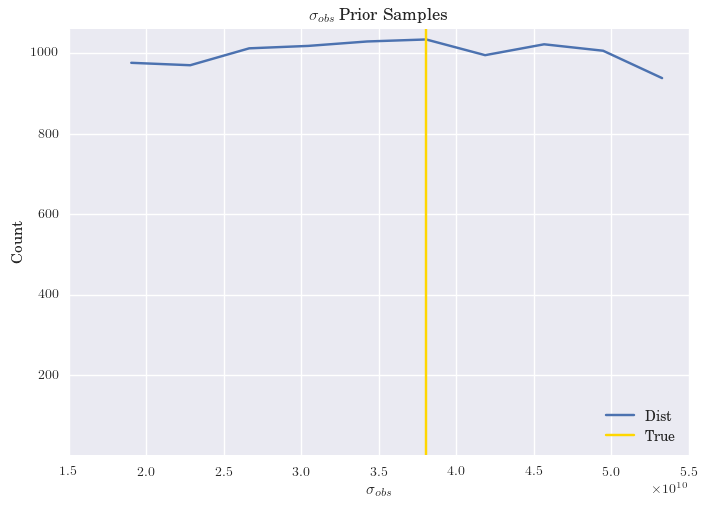

In [13]:
vals, bins = np.histogram(prior, bins=10)
plt.plot(bins[:-1], vals, label='Dist')
plt.axvline(x=sigma_obs, ymin=0, ymax=1060, label='True', color='gold')
plt.gca().set_ylim([1, 1060])
plt.title('$\sigma_{obs}$ Prior Samples')
plt.ylabel('Count')
plt.xlabel('$\sigma_{obs}$')
plt.legend(loc=4)

### Still working on ...

In [16]:
lum = fov['lum'].as_matrix()
lum_obs = fov['lum_obs'].as_matrix()
log_likelihoods = []
norm = np.log(2 * np.pi * sigma_obs ** 2) ** (len(prior) / 2.) # going to ignore because inf
for i,sigma in enumerate(prior[:100]):
    lum_pred = np.random.normal(lum, sigma, len(fov))
    chi2 = sum((lum_pred - lum_obs) ** 2) / (sigma_obs ** 2)
    log_likelihoods.append(- chi2)

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: overflow encountered in double_scalars


In [ ]:
np.argmax(log_likelihoods)

In [ ]:
prior[90:]

### Questions
- Which halo finder?
- What to present?
- Where can we find luminosity data?
- How to use HMFCalc API to get prior P(M)?
- Review connection to Pangloss.
- We are interested in luminosity at the galaxy level as opposed to the star level right? 